In [1]:
import pandas as pd
import numpy as np
from sklearn import ensemble
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from xgboost import XGBClassifier
!pip install catboost
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from scipy.sparse import lil_matrix
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import copy
from sklearn.naive_bayes import MultinomialNB
from sklearn import svm
import matplotlib.pyplot as plt
from lightgbm import LGBMClassifier
from imblearn.over_sampling import SMOTE 
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import LabelBinarizer
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsClassifier
import seaborn as sns
import sys


/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
"""
case_id                         	Case_ID registered in Hospital
Hospital_code                   	Unique code for the Hospital
Hospital_type_code	                Unique code for the type of Hospital
City_Code_Hospital	                City Code of the Hospital
Hospital_region_code            	Region Code of the Hospital
Available Extra Rooms in Hospital	Number of Extra rooms available in the Hospital
Department                      	Department overlooking the case
Ward_Type	                        Code for the Ward type
Ward_Facility_Code              	Code for the Ward Facility
Bed Grade	                        Condition of Bed in the Ward
patientid	                        Unique Patient Id
City_Code_Patient	                City Code for the patient
Type of Admission	                Admission Type registered by the Hospital
Severity of Illness	                Severity of the illness recorded at the time of admission
Visitors with Patient	            Number of Visitors with the patient
Age	                                Age of the patient
Admission_Deposit	                Deposit at the Admission Time
Stay                            	Stay Days by the patient
"""

'\ncase_id                         \tCase_ID registered in Hospital\nHospital_code                   \tUnique code for the Hospital\nHospital_type_code\t                Unique code for the type of Hospital\nCity_Code_Hospital\t                City Code of the Hospital\nHospital_region_code            \tRegion Code of the Hospital\nAvailable Extra Rooms in Hospital\tNumber of Extra rooms available in the Hospital\nDepartment                      \tDepartment overlooking the case\nWard_Type\t                        Code for the Ward type\nWard_Facility_Code              \tCode for the Ward Facility\nBed Grade\t                        Condition of Bed in the Ward\npatientid\t                        Unique Patient Id\nCity_Code_Patient\t                City Code for the patient\nType of Admission\t                Admission Type registered by the Hospital\nSeverity of Illness\t                Severity of the illness recorded at the time of admission\nVisitors with Patient\t            Numbe

In [3]:
!cp -r --recursive  "/content/drive/My Drive/DataScienceCompetitions/healthcare/test.csv"   "/content"
!cp -r --recursive  "/content/drive/My Drive/DataScienceCompetitions/healthcare/train.csv"   "/content"
!cp -r --recursive  "/content/drive/My Drive/DataScienceCompetitions/healthcare/sample_submission_lfbv3c3.csv"   "/content"
!cp -r --recursive  "/content/drive/My Drive/DataScienceCompetitions/healthcare/train_data_dict.csv"   "/content"

In [2]:
df_train = pd.read_csv('/content/train.csv')
df_train = df_train.dropna()
df_train['train_flag'] = 1
print(df_train.shape)

df_test = pd.read_csv('/content/test.csv')
df_test["Bed Grade"] = df_test["Bed Grade"].replace( np.nan, 3.0)
df_test["City_Code_Patient"] = df_test["City_Code_Patient"].replace( np.nan, 8.0)
df_test['train_flag'] = 0
df_test['Stay'] = "zzzzz"
print(df_test.shape)

df_data = pd.concat([df_train,df_test])
print(df_data.shape)
df_data = df_data.reset_index(drop=True)
df_data.head()

(313793, 19)
(137057, 19)
(450850, 19)


,case_id,Hospital_code,Hospital_type_code,City_Code_Hospital,Hospital_region_code,Available Extra Rooms in Hospital,Department,Ward_Type,Ward_Facility_Code,Bed Grade,patientid,City_Code_Patient,Type of Admission,Severity of Illness,Visitors with Patient,Age,Admission_Deposit,Stay,train_flag
0,1,8,c,3,Z,3,radiotherapy,R,F,2.0,31397,7.0,Emergency,Extreme,2,51-60,4911.0,0-10,1
1,2,2,c,5,Z,2,radiotherapy,S,F,2.0,31397,7.0,Trauma,Extreme,2,51-60,5954.0,41-50,1
2,3,10,e,1,X,2,anesthesia,S,E,2.0,31397,7.0,Trauma,Extreme,2,51-60,4745.0,31-40,1
3,4,26,b,2,Y,2,radiotherapy,R,D,2.0,31397,7.0,Trauma,Extreme,2,51-60,7272.0,41-50,1
4,5,26,b,2,Y,2,radiotherapy,S,D,2.0,31397,7.0,Trauma,Extreme,2,51-60,5558.0,41-50,1


In [3]:
df_data["Bed Grade"] = df_data["Bed Grade"].astype("int") 
df_data["City_Code_Patient"] = df_data["City_Code_Patient"].astype("int") 
df_data["Admission_Deposit"] = df_data["Admission_Deposit"].astype("int") 

le = LabelEncoder()
df_data["Hospital_type_code"] = le.fit_transform(df_data["Hospital_type_code"])

le = LabelEncoder()
df_data["Hospital_region_code"] = le.fit_transform(df_data["Hospital_region_code"])

le = LabelEncoder()
df_data["Department"] = le.fit_transform(df_data["Department"])

le = LabelEncoder()
df_data["Ward_Type"] = le.fit_transform(df_data["Ward_Type"])

le = LabelEncoder()
df_data["Ward_Facility_Code"] = le.fit_transform(df_data["Ward_Facility_Code"])

le = LabelEncoder()
df_data["Type of Admission"] = le.fit_transform(df_data["Type of Admission"])

le = LabelEncoder()
df_data["Severity of Illness"] = le.fit_transform(df_data["Severity of Illness"])

le = LabelEncoder()
df_data["Age"] = le.fit_transform(df_data["Age"])

le = LabelEncoder()
df_data["Stay"] = le.fit_transform(df_data["Stay"])
mapping_dict = dict(zip(le.transform(le.classes_) , le.classes_))

print(df_data.shape)
print(mapping_dict)
df_data["Stay"].value_counts()

(450850, 19)
{0: '0-10', 1: '11-20', 2: '21-30', 3: '31-40', 4: '41-50', 5: '51-60', 6: '61-70', 7: '71-80', 8: '81-90', 9: '91-100', 10: 'More than 100 Days', 11: 'zzzzz'}


11    137057
2      86316
1      77095
3      54312
5      34463
0      23250
4      11541
7      10096
10      6548
8       4761
9       2713
6       2698
Name: Stay, dtype: int64

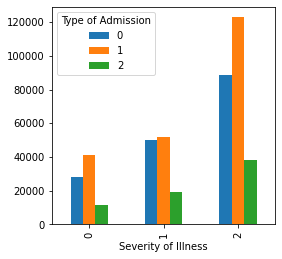

In [5]:
severity_admission = pd.crosstab(df_data['Severity of Illness'], df_data['Type of Admission'])
severity_admission.plot(kind="bar", figsize=(4, 4))
plt.show()

In [6]:
# arr = ['case_id', 'Hospital_code', 'Hospital_type_code', 'City_Code_Hospital',
#        'Hospital_region_code', 'Available Extra Rooms in Hospital',
#        'Department', 'Ward_Type', 'Ward_Facility_Code', 'Bed Grade',
#        'patientid', 'City_Code_Patient', 'Type of Admission',
#        'Severity of Illness', 'Visitors with Patient', 'Age',
#        'Admission_Deposit', 'Stay']
# for i in  arr:
#     for j in arr:
#         if i!=j:
#             df_group = aa.groupby([i,j],as_index=False)
#             print(len(df_group))
#             print(df_group.size())
#             print("********************************************")
#             print("********************************************")
#             print("********************************************")


In [ ]:
df_train = pd.read_csv('/content/train.csv')
df_train = df_train.dropna()
df_train['train_flag'] = 1
print(df_train.shape)

df_test = pd.read_csv('/content/test.csv')
df_test["Bed Grade"] = df_test["Bed Grade"].replace(np.nan, 3.0)
df_test["City_Code_Patient"] = df_test["City_Code_Patient"].replace( np.nan, 8.0)
df_test['train_flag'] = 0
df_test['Stay'] = "zzzzz"
print(df_test.shape)

df_data = pd.concat([df_train,df_test])
print(df_data.shape)
df_data = df_data.reset_index(drop=True)




df_data["Bed Grade"] = df_data["Bed Grade"].astype("int") 
df_data["City_Code_Patient"] = df_data["City_Code_Patient"].astype("int") 
df_data["Admission_Deposit"] = df_data["Admission_Deposit"].astype("int") 

le = LabelEncoder()
df_data["Hospital_type_code"] = le.fit_transform(df_data["Hospital_type_code"])

le = LabelEncoder()
df_data["Hospital_region_code"] = le.fit_transform(df_data["Hospital_region_code"])

le = LabelEncoder()
df_data["Department"] = le.fit_transform(df_data["Department"])

le = LabelEncoder()
df_data["Ward_Type"] = le.fit_transform(df_data["Ward_Type"])

le = LabelEncoder()
df_data["Ward_Facility_Code"] = le.fit_transform(df_data["Ward_Facility_Code"])

le = LabelEncoder()
df_data["Type of Admission"] = le.fit_transform(df_data["Type of Admission"])

le = LabelEncoder()
df_data["Severity of Illness"] = le.fit_transform(df_data["Severity of Illness"])

le = LabelEncoder()
df_data["Age"] = le.fit_transform(df_data["Age"])

le = LabelEncoder()
df_data["Stay"] = le.fit_transform(df_data["Stay"])
mapping_dict = dict(zip(le.transform(le.classes_) , le.classes_))
print(mapping_dict)



df_data["HTC&HC"]    = df_data.groupby(["Hospital_type_code" , "Hospital_code"]).ngroup().astype('int')
df_data["HTC&CCH"]   = df_data.groupby(["Hospital_type_code" , "City_Code_Hospital" ]).ngroup().astype('int')
df_data["CCH&HC"]    = df_data.groupby(["City_Code_Hospital" , "Hospital_code"]).ngroup().astype('int')

df_data["HTC&HRC"]    = df_data.groupby(["Hospital_type_code" , "Hospital_region_code"]).ngroup().astype('int')
df_data["CCH&HRC"]   = df_data.groupby(["City_Code_Hospital" , "Hospital_region_code"]).ngroup().astype('int')
df_data["HC&HRC"]    = df_data.groupby(["Hospital_code"      , "Hospital_region_code"]).ngroup().astype('int')
 
df_data["HC&WFC"]     = df_data.groupby(["Hospital_code"      , "Ward_Facility_Code"]).ngroup().astype('int')
df_data["HTC&WFC"]    = df_data.groupby(["Hospital_type_code"      , "Ward_Facility_Code"]).ngroup().astype('int')
df_data["CCH&WFC"]    = df_data.groupby(["City_Code_Hospital"      , "Ward_Facility_Code"]).ngroup().astype('int')
df_data["HRC&WFC"]    = df_data.groupby(["Hospital_region_code"      , "Ward_Facility_Code"]).ngroup().astype('int')

df_data["VWP&TOA"]    = df_data.groupby(["Visitors with Patient"      , "Type of Admission"]).ngroup().astype('int')



df_data["pat_hos"] = 0
df_data["a1"] = 0
df_data["a2"] = 0
df_data["a3"] = 0
df_data["a4"] = 0
df_data["a5"] = 0
df_data["a6"] = 0
df_data["a7"] = 0
df_data["a8"] = 0
df_data["a9"] = 0
df_data["a10"] = 0
df_data["a11"] = 0
df_data["a12"] = 0
df_data["a13"] = 0
df_data["a14"] = 0
df_data["a15"] = 0
pat_ct = df_data["patientid"].value_counts()
a1 = df_data.groupby(["patientid" , "Hospital_code"],as_index=False)
a2 = df_data.groupby(["patientid" , "Hospital_type_code"],as_index=False)
a3 = df_data.groupby(["patientid" , "City_Code_Hospital"],as_index=False)
a4 = df_data.groupby(["patientid" , "Hospital_region_code"],as_index=False)
a5 = df_data.groupby(["patientid" , "Available Extra Rooms in Hospital"],as_index=False)
a6 = df_data.groupby(["patientid" , "Department"],as_index=False)
a7 = df_data.groupby(["patientid" , "Ward_Type"],as_index=False)
a8 = df_data.groupby(["patientid" , "Ward_Facility_Code"],as_index=False)
a9 = df_data.groupby(["patientid" , "Bed Grade"],as_index=False)
a10 = df_data.groupby(["patientid" , "City_Code_Patient"],as_index=False)
a11 = df_data.groupby(["patientid" , "Type of Admission"],as_index=False)
a12 = df_data.groupby(["patientid" , "Severity of Illness"],as_index=False)
a13 = df_data.groupby(["patientid" , "Visitors with Patient"],as_index=False)
a14 = df_data.groupby(["patientid" , "Age"],as_index=False)
a15 = df_data.groupby(["patientid" , "Admission_Deposit"],as_index=False)

for i in range(len(df_data)):
    pat_id = df_data.iloc[i]["patientid"]
    arr = df_data.iloc[i]

    df_data["pat_hos"][i] = pat_ct[pat_id]
    df_data["a1"][i] = len(a1.get_group((pat_id,arr["Hospital_code"])))
    df_data["a2"][i] = len(a2.get_group((pat_id,arr["Hospital_type_code"])))
    df_data["a3"][i] = len(a3.get_group((pat_id,arr["City_Code_Hospital"])))
    df_data["a4"][i] = len(a4.get_group((pat_id,arr["Hospital_region_code"])))
    df_data["a5"][i] = len(a5.get_group((pat_id,arr["Available Extra Rooms in Hospital"])))
    df_data["a6"][i] = len(a6.get_group((pat_id,arr["Department"])))
    df_data["a7"][i] = len(a7.get_group((pat_id,arr["Ward_Type"])))
    df_data["a8"][i] = len(a8.get_group((pat_id,arr["Ward_Facility_Code"])))
    df_data["a9"][i] = len(a9.get_group((pat_id,arr["Bed Grade"])))
    df_data["a10"][i] = len(a10.get_group((pat_id,arr["City_Code_Patient"])))
    df_data["a11"][i] = len(a11.get_group((pat_id,arr["Type of Admission"])))
    df_data["a12"][i] = len(a12.get_group((pat_id,arr["Severity of Illness"])))
    df_data["a13"][i] = len(a13.get_group((pat_id,arr["Visitors with Patient"])))
    df_data["a14"][i] = len(a14.get_group((pat_id,arr["Age"])))
    df_data["a15"][i] = len(a15.get_group((pat_id,arr["Admission_Deposit"])))
    


    sys.stdout.write('\r')
    sys.stdout.write(str(i))
    sys.stdout.flush()


df_data.head()


In [11]:
df_data = df_data.sample(frac=1)
train = df_data[df_data["train_flag"] == 1]
test  = df_data[df_data["train_flag"] == 0]
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)
print(train.shape , test.shape)
train

(313793, 46) (137057, 46)


,case_id,Hospital_code,Hospital_type_code,City_Code_Hospital,Hospital_region_code,Available Extra Rooms in Hospital,Department,Ward_Type,Ward_Facility_Code,Bed Grade,patientid,City_Code_Patient,Type of Admission,Severity of Illness,Visitors with Patient,Age,Admission_Deposit,Stay,train_flag,HTC&HC,HTC&CCH,CCH&HC,HTC&HRC,CCH&HRC,HC&HRC,HC&WFC,HTC&WFC,CCH&WFC,HRC&WFC,VWP&TOA,pat_hos,a1,a2,a3,a4,a5,a6,a7,a8,a9,a10,a11,a12,a13,a14,a15
0,125273,26,1,2,1,6,0,0,3,4,57794,8,1,0,4,2,4432,3,1,14,6,8,4,1,25,25,4,1,4,11,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,263088,27,0,7,1,5,2,0,2,3,4591,8,1,2,4,3,6827,1,1,10,4,25,1,6,26,26,1,7,3,11,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,241904,16,2,3,2,3,3,2,0,3,80996,6,1,1,3,7,5353,1,1,20,8,11,5,2,15,15,6,2,5,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,223046,6,0,6,0,4,2,1,5,3,4425,2,1,2,3,5,3705,2,1,2,3,22,0,5,5,5,3,6,1,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,203853,29,0,4,0,2,2,3,5,2,57656,8,1,2,4,4,5588,5,1,11,1,17,0,3,28,28,3,4,1,11,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
313788,11367,28,1,11,0,3,2,2,5,4,52804,8,1,1,2,6,6248,4,1,15,7,30,3,9,27,27,5,10,1,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
313789,45001,26,1,2,1,3,2,2,3,2,4856,5,0,2,3,5,7206,3,1,14,6,8,4,1,25,25,4,1,4,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
313790,30252,26,1,2,1,2,3,3,3,3,16152,8,2,0,4,7,5653,2,1,14,6,8,4,1,25,25,4,1,4,12,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
313791,162170,26,1,2,1,4,2,1,3,4,10985,8,0,2,4,9,4614,3,1,14,6,8,4,1,25,25,4,1,4,10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


(313793, 44)


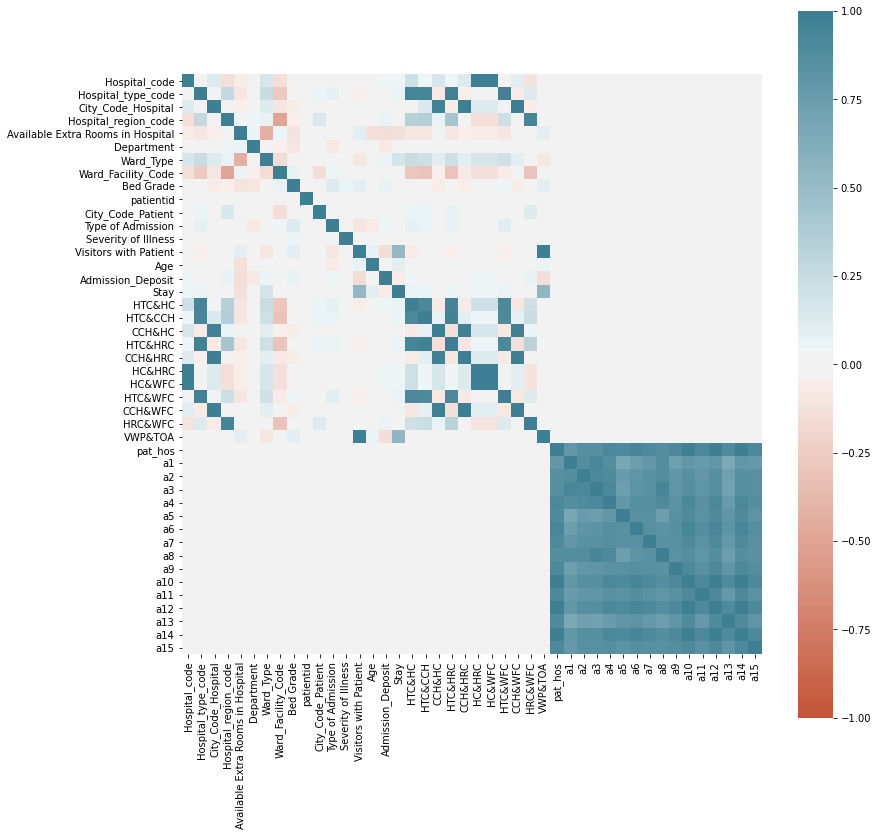

In [12]:
# get complete heatmap of all corelation coefficients
df = train.drop(["case_id","train_flag"] , axis=1)
print(df.shape)
corr = df.corr()
fig, ax = plt.subplots(figsize=(13,13))
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)




In [15]:
def train_model(X , Y):
    # model = CatBoostClassifier(n_estimators=800, depth=5, verbose=0)
    # model = CatBoostClassifier( n_estimators=800, depth=4, verbose=0)
    # model = RandomForestClassifier()
    # model = XGBClassifier(n_estimators=100 , max_depth=8, verbose=0)
    model = LGBMClassifier(max_depth=9 , n_estimators=120 , num_leaves=50)
    print(X.columns)
    model.fit(X , Y)
    return model



def prediction(model):
    X = test[array1]
    print(X.shape)
    print(X.columns)


    col1 = test["case_id"].values
    col2 = model.predict(X)
    return col1,col2


In [16]:
array1 = ["case_id", "Hospital_code", "Hospital_type_code", "City_Code_Hospital", "Hospital_region_code", "Available Extra Rooms in Hospital", "Department", "Ward_Type", "Ward_Facility_Code", "Bed Grade", "patientid", "City_Code_Patient",	"Type of Admission", "Severity of Illness",	"Visitors with Patient", "Age", "Admission_Deposit", "Stay", "train_flag"]
print(len(array1))

col_to_drop = ["case_id", "train_flag", "Stay", "patientid"]
for i in col_to_drop:
    array1.remove(i)
print(len(array1))

col_to_add = ["HTC&HC" , "HTC&WFC" ,"pat_hos", "a1", "a2", "a3", "a5"]
array1.extend(col_to_add)
print(len(array1))





X = train[array1]
Y = train["Stay"]
print(X.shape, Y.shape)
m = train_model(X , Y)

19
15
22
(313793, 22) (313793,)
Index(['Hospital_code', 'Hospital_type_code', 'City_Code_Hospital',
       'Hospital_region_code', 'Available Extra Rooms in Hospital',
       'Department', 'Ward_Type', 'Ward_Facility_Code', 'Bed Grade',
       'City_Code_Patient', 'Type of Admission', 'Severity of Illness',
       'Visitors with Patient', 'Age', 'Admission_Deposit', 'HTC&HC',
       'HTC&WFC', 'pat_hos', 'a1', 'a2', 'a3', 'a5'],
      dtype='object')


In [17]:
# print(m.score(X,Y))
col1,col2 =  prediction(m)
print(col1.shape , col2.shape)



# col3 = []
# if col2.shape == (len(df_test),1):
#     for i in range(len(df_test)):
#         col3.append(col2[i][0])
#     col2 = copy.deepcopy(col3)
# print(np.array(col2).shape)




(137057, 22)
Index(['Hospital_code', 'Hospital_type_code', 'City_Code_Hospital',
       'Hospital_region_code', 'Available Extra Rooms in Hospital',
       'Department', 'Ward_Type', 'Ward_Facility_Code', 'Bed Grade',
       'City_Code_Patient', 'Type of Admission', 'Severity of Illness',
       'Visitors with Patient', 'Age', 'Admission_Deposit', 'HTC&HC',
       'HTC&WFC', 'pat_hos', 'a1', 'a2', 'a3', 'a5'],
      dtype='object')
(137057,) (137057,)


In [18]:
c1 , c2 = [] , []
c2 = map(lambda x: mapping_dict[x], col2)



diction = {'case_id': col1, 'Stay': c2 } 
df_fin = pd.DataFrame(diction) 

filename = "sub.csv"

df_fin.to_csv(filename , index=False)
from google.colab import files
files.download(filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>